# A simple demonstration of the Bellman Operator

What we're going to do is build a very simple environment composed of 3 states and 2 actions, and some rewards for these actions. We'll then calculate the dynamics matrix for a given policy $\pi$ from the $\mathcal{P}_{a}^{s,s'}$ matrices.

This will be used to implement the Bellman Operator (or Bellman Backup Operator, I need to check the naming here) and will show that repeatedly applying the operator yields the true state-value (or, extension, action-value) function for a policy $\pi$. Let's do this!

In [78]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
n_states = 3
n_actions = 2
transitions = np.zeros((n_actions, n_states, n_states)) # just to show dimensionality

# an arbitrary policy
policy = np.array(
    [[0.5, 0.5],
     [0.4, 0.6],
     [0.8, 0.2]]
) # .shape = (n_states, n_actions)

## The Bellman Equation for the State-Value Function

The Bellman Equation for state-value functions reads (in this case):

$$
V_\pi(s) = R(s) + \gamma \sum_a \sum_{s'} \mathcal{P}_{a}^{s,s'} V_\pi(s')
$$

And the Bellman Operator $T$ is:

$$
TV(s) = R(s) + \gamma \sum_a \sum_{s'} \mathcal{P}_{a}^{s, s'} V(s')
$$

You should interpret $TV$ as a _new function_. What this does is replace the previous value of V(s) with a one-step lookahead through its neighbors and the chance of reaching them, plus the immediate reward.

To calculate the true value function for a policy $\pi$, we'll repeatedly apply the Bellman Operator to an initial estimate of this value function. In other words, we'll do:
$$ \hat{V}_\pi \gets T \hat{V}_\pi$$
over and over again. This will converge to the true value function of our policy in the given MDP. This happens because $V_\pi$ is the **fixed point** of the Bellman Operator.

In [79]:
# Let's introduce the environment's data:

gamma = 0.9 # discount factor

# simplification: we actually might want the reward to depend
# on the action as well. Think of this as an averaged reward over actions, per state.
rewards_per_state = np.array([1.0, -0.5, 2.0])


# The dynamics have some noise: not always will our command take us the direction
# we want, but it will always move us at most one step to the left or to the right.
transitions[0] = np.array([
    [0.9, 0.1, 0.0],
    [0.8, 0.1, 0.1],
    [0.0, 0.9, 0.1]
])
transitions[1] = np.array([
    [0.1, 0.9, 0.0],
    [0.1, 0.1, 0.8],
    [0.0, 0.1, 0.9]
])

In [80]:
assert policy.shape == (n_states, n_actions)
assert transitions.shape == (n_actions, n_states, n_states)
assert rewards_per_state.shape == (n_states,)

In [81]:
# A helper to apply a function n times over itself
def apply_n_times(f, *args, n=1, accum=None):
    if accum is not None:
        accum.append(f(*args))
    if n == 1:
        return f(*args), accum
    else:
        return apply_n_times(f, f(*args), n=n-1, accum=accum)

In [82]:
def incr(x): return x + 1
# A small test
apply_n_times(incr, 0, n=5)

(5, None)

In [83]:
# The policy allows us to simplify the transition tensor by
# averaging its components w.r.t. the probability of each action in each
# state.
transitions_under_policy = np.zeros((n_states, n_states))
for action in range(n_actions):
    transitions_under_policy += policy[:, action][:,np.newaxis] * transitions[action]
# Or, in less space but maybe less understandably:
transitions_under_policy = np.tensordot(transitions, policy, axes=(0, 1))[np.arange(n_states), :, np.arange(n_states)]
# Should also test if this /\ is faster.

# Sanity check
assert np.all(np.isclose(np.sum(transitions_under_policy, axis=1), 1.0))

# The value function guess is initially zero.
def bellman_operator(value_function):
    # translation of the equation described above
    return rewards_per_state + gamma * transitions_under_policy @ value_function

In [88]:
value_f = np.zeros(n_states)
value_f, hist = apply_n_times(bellman_operator, value_f, n=250, accum=[])

In [89]:
value_f

array([ 6.74222258,  6.01827204,  7.8435629 ])

In [90]:
hist

[array([ 1. , -0.5,  2. ]),
 array([ 1.225,  0.733,  2.135]),
 array([ 1.8811  ,  0.9841  ,  2.987768]),
 array([ 2.28934   ,  1.63018062,  3.35454831]),
 array([ 2.76378428,  1.99959915,  3.8706646 ]),
 array([ 3.14352254,  2.43664918,  4.23746855]),
 array([ 3.51107728,  2.77751842,  4.61437599]),
 array([ 3.82986806,  3.11029305,  4.92959125]),
 array([ 4.1230725 ,  3.39678996,  5.22497952]),
 array([ 4.38393811,  3.66109231,  5.48490732]),
 array([ 4.62026369,  3.89574176,  5.72175579]),
 array([ 4.83220245,  4.10852865,  5.93345487]),
 array([ 5.023329  ,  4.2992377 ,  6.12470852]),
 array([ 5.19515501,  4.4712735 ,  6.2964741 ]),
 array([ 5.34989283,  4.62590751,  6.45124309]),
 array([ 5.48911015,  4.76517679,  6.59044528]),
 array([ 5.61442912,  4.89046997,  6.71577194]),
 array([ 5.72720459,  5.00325832,  6.82854364]),
 array([ 5.82870831,  5.10475564,  6.93004925]),
 array([ 5.92005878,  5.1961093 ,  7.02139878]),
 array([ 6.00227564,  5.27832457,  7.10361611]),
 array([ 6.07

[2, 8, 14, 21, 27, 34, 40, 47, 54, 60, 67]


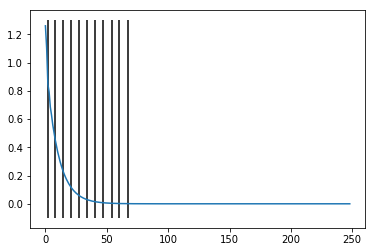

In [129]:
# Let's check the convergence.
# We'll measure the L2 distance between each consecutive pair of value functions
dists = np.array([np.linalg.norm(v1 - v2) for (v1, v2) in zip(hist, hist[1:])])
plt.plot(dists)
plt.vlines([np.where(dists <= 10**(-x))[0][0] for x in range(11)], -0.1, 1.3)
print([np.where(dists <= 10**(-x))[0][0] for x in range(11)])
plt.show()

true_value_func = np.copy(value_f)

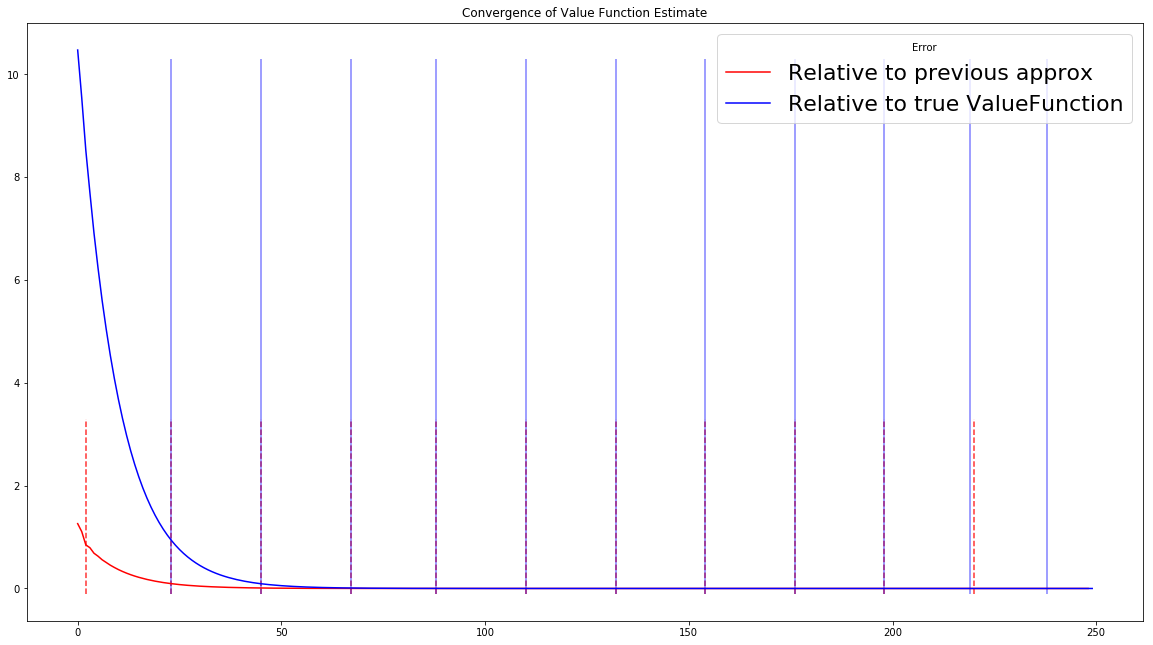

In [128]:
dists2 = np.array([np.linalg.norm(v - true_value_func) for v in hist])
f = plt.figure(figsize=(20,11))
plt.plot(dists, c = 'r', label='Relative to previous approx')
plt.vlines([np.where(dists <= 10**(-x))[0][0] for x in range(11)], -0.1, 3.3, colors=(1,0,0,.8), linestyles='--')
plt.plot(dists2, c = 'b', label='Relative to true ValueFunction')
plt.vlines([np.where(dists2 <= 10**(-x))[0][0] for x in range(11)], -0.1, 10.3, colors=(0,0,1,.5), linestyles='-')
plt.legend(title='Error', loc='best', fontsize=22)
plt.title('Convergence of Value Function Estimate')
plt.show()
